In [1]:
import aim_modules as am
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.patches as mpatches
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
colors = sns.color_palette("Set2")
sns.set()
sns.set(font_scale=1.5)  # crazy big
sns.set_palette(colors)
%matplotlib inline
import pandas as pd
from os import listdir
from os.path import isfile, join

/Users/ChrisM/anaconda/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


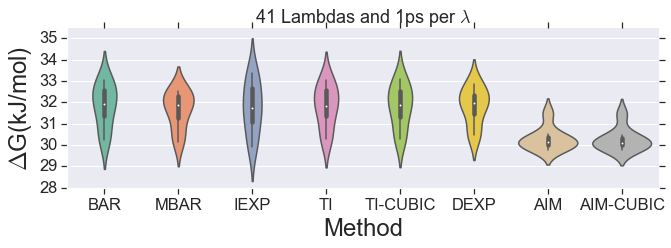

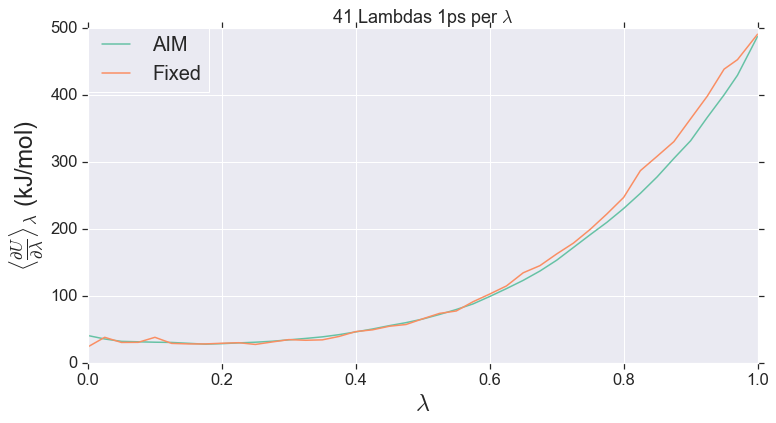

In [2]:
# collect all of the TI information
runs = ["run01","run02","run03","run04","run05","run06","run07","run08"]
times = ["1ps"]
ti_home = "/Users/ChrisM/Documents/workspace/tripep/TI/fortyoneLambdas/"
names = ["N","CoulL","VdwL","Count","G","dG","AIMCount","dGCoulL","dGVdwL"]
ti_names = ["dGCoulL","dGVdwL"]

# create a dictionary to hold our results
# each result is a dataframe
# these results aren't comparable because they are for a different setup but we use
# this to init our dictionary
results = {}
for i in times:
    root = ti_home+i
    results[i] = am.import_pickle(root, runs, "results")

# collect AIM results
aim_home = "/Users/ChrisM/Documents/workspace/tripep/AIM/fortyoneLambdas/"
aim_averages = {}
num_lams = 41
avg = np.zeros(num_lams-1)

cubic_states = {}
trapz_states = {}
aim_dhdl_states = {}
aim_dgdcoul = {}
aim_dgdvdw = {}
aim_dhdl_states = {}
aim_dgdcoul_averages = {}
aim_dgdvdw_averages = {}
aim_dgdcoulavg = np.zeros(num_lams)
aim_dgdvdwavg = np.zeros(num_lams)

for j in times:
    files = [f for f in listdir(aim_home+j) if isfile(join(aim_home+j, f))]
    totals = []
    cubics = []
    cubic_states[j] = {}
    trapz_states[j] = {}
    aim_dhdl_states[j] = {}
    aim_dgdcoul[j] = {}
    aim_dgdvdw[j] = {}
    for i in range(len(files)):
        cubic_states[j][i] = []
        trapz_states[j][i] = []
        aim_dhdl_states[j][i] = []
        file_in = aim_home+j+"/"+files[i]
        aim, aim_cubic, counts, trapz, cubic, dhdl, dgdcoul, dgdvdw, coulLambdas, vdwLambdas= am.quad_AIM(file_in, names)
        totals.append(aim)
        cubics.append(aim_cubic)
        trapz_states[j][i] = trapz
        cubic_states[j][i] = cubic
        aim_dhdl_states[j][i] = dhdl
        aim_dgdcoul[j][i] = dgdcoul
        aim_dgdvdw[j][i] = dgdvdw
        
        aim_averages[j] = {}            
        aim_dgdcoul[j][i] = dgdcoul
        aim_dgdvdw[j][i] = dgdvdw

        for k in range(num_lams-1):
            avg[k] += trapz_states[j][i][k]/len(files)
        for k in range(num_lams):
            aim_dgdcoulavg[k] += aim_dgdcoul[j][i][k]/len(files)
            aim_dgdvdwavg[k] += aim_dgdvdw[j][i][k]/len(files)
                    
    results[j]['AIM'] = np.array(totals)
    results[j]['AIM-CUBIC'] = np.array(cubics)

    aim_averages[j] = avg
        
# Now let's look at the dhdl breakdown

# collect TI results
cubic_states = {}
trapz_states = {}
ti_dhdl_states = {}
ti_dgdcoul_averages = {}
ti_dgdvdw_averages = {}
ti_averages = {}
ti_dgdcoulavg = np.zeros(num_lams)
ti_dgdvdwavg = np.zeros(num_lams)
ti_dgdcoul = {}
ti_dgdvdw = {}
avg = np.zeros(num_lams-1)

for j in times:
    totals = []
    cubics = []
    cubic_states[j] = {}
    trapz_states[j] = {}
    ti_dhdl_states[j] = {}
    ti_dgdcoul[j] = {}
    ti_dgdvdw[j] = {}
    for i in runs:
        file_in = ti_home+j+"/"+i+"/A2VTI{0}.out".format(j)
        ti, ti_cubic, trapz, cubic, dhdl, dgdcoul, dgdvdw = am.quad_TI(file_in, ti_names, coulLambdas, vdwLambdas)
        totals.append(ti)
        cubics.append(ti_cubic)
        trapz_states[j][i] = trapz
        cubic_states[j][i] = cubic
        ti_dhdl_states[j][i] = dhdl
        ti_dgdcoul[j][i] = dgdcoul
        ti_dgdvdw[j][i] = dgdvdw

        for k in range(num_lams-1):
            avg[k] += trapz_states[j][i][k]/len(runs)
        for k in range(num_lams):
            ti_dgdcoulavg[k] += ti_dgdcoul[j][i][k]/len(runs)
            ti_dgdvdwavg[k] += ti_dgdvdw[j][i][k]/len(runs)
            
    ti_averages[j] = avg
    
    df_allk = {}
    df_allk['AIM_vdw_1ps'] = aim_dgdvdwavg
    df_allk['FIXED_vdw_1ps'] = ti_dgdvdwavg
    df_allk['Coul_Lambdas_1ps'] = coulLambdas
    df_allk['VdW_Lambdas_1ps'] = vdwLambdas
    
    fortyone_lambdas_1ps = pd.DataFrame.from_dict(df_allk)
    fortyone_results_1ps = results[j].apply(np.vectorize(am.convert_to_kcal))
    fortyone_results_1ps['Number of Lambdas'] = 41

    from mpl_toolkits.axes_grid.inset_locator import inset_axes
    columns = ['BAR', 'MBAR', 'IEXP', 'TI', 'TI-CUBIC', 'DEXP', 'AIM', 'AIM-CUBIC']

    sns.catplot(data=fortyone_results_1ps[columns], kind="violin", height=3, aspect=3);


    plt.ylabel(r'$\Delta$G(kJ/mol)', fontsize = 24);
    plt.xlabel('Method', fontsize = 24);
    plt.ylim(28, 35.5)
    plt.title("41 Lambdas and {0} per $\lambda$".format(j));

    # plot with various axes scales
    plt.figure(figsize = (12,6))
    sns.lineplot(x="VdW_Lambdas_1ps", y='AIM_vdw_1ps', label="AIM", data=fortyone_lambdas_1ps);
    sns.lineplot(x="VdW_Lambdas_1ps", y="FIXED_vdw_1ps", label="Fixed", data=fortyone_lambdas_1ps);
    plt.ylabel(r'$\langle\frac{\partial U}{\partial \lambda}\rangle$$_{\lambda}$ (kJ/mol)', fontsize = 24);
    plt.xlabel(r'$\lambda$', fontsize = 24);
    plt.title("41 Lambdas {0} per $\lambda$".format(j));
    plt.legend(loc=0, borderaxespad=0., fontsize=20, ncol=1);

    plt.show()

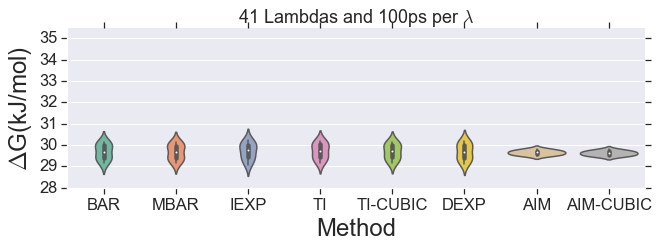

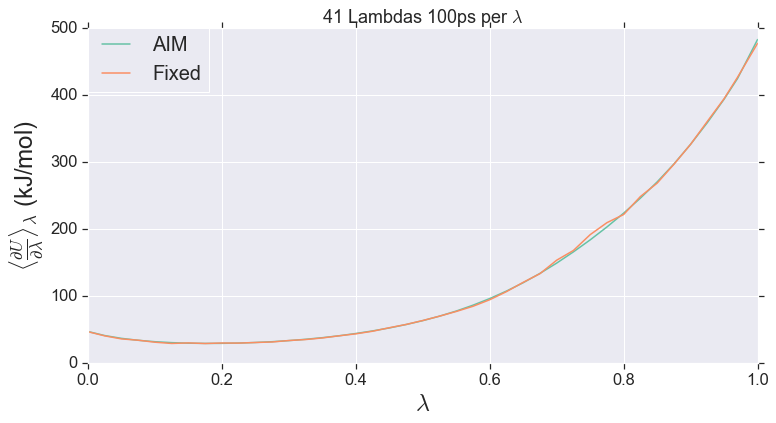

In [3]:
# collect all of the TI information
runs = ["run01","run02","run03","run04","run05","run06","run07","run08"]
times = ["100ps"]
ti_home = "/Users/ChrisM/Documents/workspace/tripep/TI/fortyoneLambdas/"
names = ["N","CoulL","VdwL","Count","G","dG","AIMCount","dGCoulL","dGVdwL"]
ti_names = ["dGCoulL","dGVdwL"]

# create a dictionary to hold our results
# each result is a dataframe
# these results aren't comparable because they are for a different setup but we use
# this to init our dictionary
#results = {}
for i in times:
    root = ti_home+i
    results[i] = am.import_pickle(root, runs, "results")

# collect AIM results
aim_home = "/Users/ChrisM/Documents/workspace/tripep/AIM/fortyoneLambdas/"
aim_averages = {}
num_lams = 41
avg = np.zeros(num_lams-1)

cubic_states = {}
trapz_states = {}
aim_dhdl_states = {}
aim_dgdcoul = {}
aim_dgdvdw = {}
aim_dhdl_states = {}
aim_dgdcoul_averages = {}
aim_dgdvdw_averages = {}
aim_dgdcoulavg = np.zeros(num_lams)
aim_dgdvdwavg = np.zeros(num_lams)

for j in times:
    files = [f for f in listdir(aim_home+j) if isfile(join(aim_home+j, f))]
    totals = []
    cubics = []
    cubic_states[j] = {}
    trapz_states[j] = {}
    aim_dhdl_states[j] = {}
    aim_dgdcoul[j] = {}
    aim_dgdvdw[j] = {}
    for i in range(len(files)):
        cubic_states[j][i] = []
        trapz_states[j][i] = []
        aim_dhdl_states[j][i] = []
        file_in = aim_home+j+"/"+files[i]
        aim, aim_cubic, counts, trapz, cubic, dhdl, dgdcoul, dgdvdw, coulLambdas, vdwLambdas= am.quad_AIM(file_in, names)
        totals.append(aim)
        cubics.append(aim_cubic)
        trapz_states[j][i] = trapz
        cubic_states[j][i] = cubic
        aim_dhdl_states[j][i] = dhdl
        aim_dgdcoul[j][i] = dgdcoul
        aim_dgdvdw[j][i] = dgdvdw
        
        aim_averages[j] = {}            
        aim_dgdcoul[j][i] = dgdcoul
        aim_dgdvdw[j][i] = dgdvdw

        for k in range(num_lams-1):
            avg[k] += trapz_states[j][i][k]/len(files)
        for k in range(num_lams):
            aim_dgdcoulavg[k] += aim_dgdcoul[j][i][k]/len(files)
            aim_dgdvdwavg[k] += aim_dgdvdw[j][i][k]/len(files)
                    
    results[j]['AIM'] = np.array(totals)
    results[j]['AIM-CUBIC'] = np.array(cubics)

    aim_averages[j] = avg
    
    
# Now let's look at the dhdl breakdown

# collect TI results
cubic_states = {}
trapz_states = {}
ti_dhdl_states = {}
ti_dgdcoul_averages = {}
ti_dgdvdw_averages = {}
ti_averages = {}
ti_dgdcoulavg = np.zeros(num_lams)
ti_dgdvdwavg = np.zeros(num_lams)
ti_dgdcoul = {}
ti_dgdvdw = {}
avg = np.zeros(num_lams-1)

for j in times:
    totals = []
    cubics = []
    cubic_states[j] = {}
    trapz_states[j] = {}
    ti_dhdl_states[j] = {}
    ti_dgdcoul[j] = {}
    ti_dgdvdw[j] = {}
    for i in runs:
        file_in = ti_home+j+"/"+i+"/A2VTI{0}.out".format(j)
        ti, ti_cubic, trapz, cubic, dhdl, dgdcoul, dgdvdw = am.quad_TI(file_in, ti_names, coulLambdas, vdwLambdas)
        totals.append(ti)
        cubics.append(ti_cubic)
        trapz_states[j][i] = trapz
        cubic_states[j][i] = cubic
        ti_dhdl_states[j][i] = dhdl
        ti_dgdcoul[j][i] = dgdcoul
        ti_dgdvdw[j][i] = dgdvdw

        for k in range(num_lams-1):
            avg[k] += trapz_states[j][i][k]/len(runs)
        for k in range(num_lams):
            ti_dgdcoulavg[k] += ti_dgdcoul[j][i][k]/len(runs)
            ti_dgdvdwavg[k] += ti_dgdvdw[j][i][k]/len(runs)
            
    ti_averages[j] = avg
 
    df_allk = {}
    df_allk['AIM_vdw_100ps'] = aim_dgdvdwavg
    df_allk['FIXED_vdw_100ps'] = ti_dgdvdwavg
    df_allk['Coul_Lambdas_100ps'] = coulLambdas
    df_allk['VdW_Lambdas_100ps'] = vdwLambdas
    
    fortyone_lambdas_100ps = pd.DataFrame.from_dict(df_allk)
    fortyone_results_100ps = results[j].apply(np.vectorize(am.convert_to_kcal))
    fortyone_results_100ps['Number of Lambdas'] = 41

    
    from mpl_toolkits.axes_grid.inset_locator import inset_axes
    columns = ['BAR', 'MBAR', 'IEXP', 'TI', 'TI-CUBIC', 'DEXP', 'AIM', 'AIM-CUBIC']

    sns.catplot(data=fortyone_results_100ps[columns], kind="violin", height=3, aspect=3);

    plt.ylabel(r'$\Delta$G(kJ/mol)', fontsize = 24);
    plt.xlabel('Method', fontsize = 24);
    plt.ylim(28, 35.5)
    plt.title("41 Lambdas and {0} per $\lambda$".format(j));

    # plot with various axes scales
    plt.figure(figsize = (12,6))
    sns.lineplot(x="VdW_Lambdas_100ps", y='AIM_vdw_100ps', label="AIM", data=fortyone_lambdas_100ps);
    sns.lineplot(x="VdW_Lambdas_100ps", y="FIXED_vdw_100ps", label="Fixed", data=fortyone_lambdas_100ps);
    plt.ylabel(r'$\langle\frac{\partial U}{\partial \lambda}\rangle$$_{\lambda}$ (kJ/mol)', fontsize = 24);
    plt.xlabel(r'$\lambda$', fontsize = 24);
    plt.title("41 Lambdas {0} per $\lambda$".format(j));
    plt.legend(loc=0, borderaxespad=0., fontsize=20, ncol=1);

    plt.show()
    

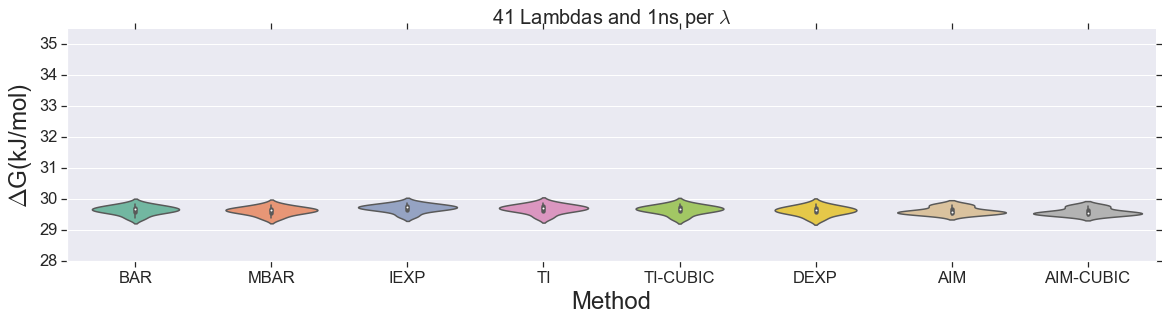

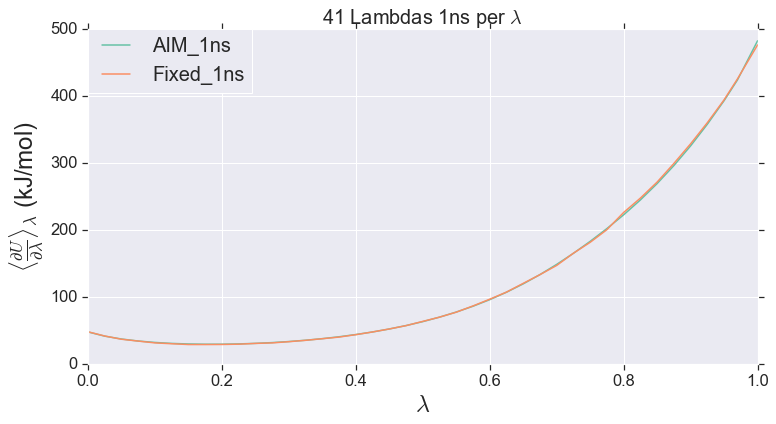

In [4]:
# collect all of the TI information
runs = ["run01","run02","run03","run04","run05","run06","run07","run08"]
times = ["1ns"]
ti_home = "/Users/ChrisM/Documents/workspace/tripep/TI/fortyoneLambdas/"
names = ["N","CoulL","VdwL","Count","G","dG","AIMCount","dGCoulL","dGVdwL"]
ti_names = ["dGCoulL","dGVdwL"]

# create a dictionary to hold our results
# each result is a dataframe
# these results aren't comparable because they are for a different setup but we use
# this to init our dictionary
#results = {}
for i in times:
    root = ti_home+i
    results[i] = am.import_pickle(root, runs, "results")

# collect AIM results
aim_home = "/Users/ChrisM/Documents/workspace/tripep/AIM/fortyoneLambdas/"
aim_averages = {}
num_lams = 41
avg = np.zeros(num_lams-1)

cubic_states = {}
trapz_states = {}
aim_dhdl_states = {}
aim_dgdcoul = {}
aim_dgdvdw = {}
aim_dhdl_states = {}
aim_dgdcoul_averages = {}
aim_dgdvdw_averages = {}
aim_dgdcoulavg = np.zeros(num_lams)
aim_dgdvdwavg = np.zeros(num_lams)

for j in times:
    files = [f for f in listdir(aim_home+j) if isfile(join(aim_home+j, f))]
    totals = []
    cubics = []
    cubic_states[j] = {}
    trapz_states[j] = {}
    aim_dhdl_states[j] = {}
    aim_dgdcoul[j] = {}
    aim_dgdvdw[j] = {}
    for i in range(len(files)):
        cubic_states[j][i] = []
        trapz_states[j][i] = []
        aim_dhdl_states[j][i] = []
        file_in = aim_home+j+"/"+files[i]
        aim, aim_cubic, counts, trapz, cubic, dhdl, dgdcoul, dgdvdw, coulLambdas, vdwLambdas= am.quad_AIM(file_in, names)
        totals.append(aim)
        cubics.append(aim_cubic)
        trapz_states[j][i] = trapz
        cubic_states[j][i] = cubic
        aim_dhdl_states[j][i] = dhdl
        aim_dgdcoul[j][i] = dgdcoul
        aim_dgdvdw[j][i] = dgdvdw
        
        aim_averages[j] = {}            
        aim_dgdcoul[j][i] = dgdcoul
        aim_dgdvdw[j][i] = dgdvdw

        for k in range(num_lams-1):
            avg[k] += trapz_states[j][i][k]/len(files)
        for k in range(num_lams):
            aim_dgdcoulavg[k] += aim_dgdcoul[j][i][k]/len(files)
            aim_dgdvdwavg[k] += aim_dgdvdw[j][i][k]/len(files)
            
    results[j]['AIM'] = np.array(totals)
    results[j]['AIM-CUBIC'] = np.array(cubics)

    aim_averages[j] = avg
      
# Now let's look at the dhdl breakdown

# collect TI results
cubic_states = {}
trapz_states = {}
ti_dhdl_states = {}
ti_dgdcoul_averages = {}
ti_dgdvdw_averages = {}
ti_averages = {}
ti_dgdcoulavg = np.zeros(num_lams)
ti_dgdvdwavg = np.zeros(num_lams)
ti_dgdcoul = {}
ti_dgdvdw = {}
avg = np.zeros(num_lams-1)

for j in times:
    totals = []
    cubics = []
    cubic_states[j] = {}
    trapz_states[j] = {}
    ti_dhdl_states[j] = {}
    ti_dgdcoul[j] = {}
    ti_dgdvdw[j] = {}
    for i in runs:
        file_in = ti_home+j+"/"+i+"/A2VTI{0}.out".format(j)
        ti, ti_cubic, trapz, cubic, dhdl, dgdcoul, dgdvdw = am.quad_TI(file_in, ti_names, coulLambdas, vdwLambdas)
        totals.append(ti)
        cubics.append(ti_cubic)
        trapz_states[j][i] = trapz
        cubic_states[j][i] = cubic
        ti_dhdl_states[j][i] = dhdl
        ti_dgdcoul[j][i] = dgdcoul
        ti_dgdvdw[j][i] = dgdvdw

        for k in range(num_lams-1):
            avg[k] += trapz_states[j][i][k]/len(runs)
        for k in range(num_lams):
            ti_dgdcoulavg[k] += ti_dgdcoul[j][i][k]/len(runs)
            ti_dgdvdwavg[k] += ti_dgdvdw[j][i][k]/len(runs)
            
    ti_averages[j] = avg
    
    df_allk = {}
    df_allk['AIM_vdw_1ns'] = aim_dgdvdwavg
    df_allk['FIXED_vdw_1ns'] = ti_dgdvdwavg
    df_allk['Coul_Lambdas_1ns'] = coulLambdas
    df_allk['VdW_Lambdas_1ns'] = vdwLambdas
    
    fortyone_lambdas_1ns = pd.DataFrame.from_dict(df_allk)
    fortyone_results_1ns = results[j].apply(np.vectorize(am.convert_to_kcal))
    fortyone_results_1ns['Number of Lambdas'] = 41

    from mpl_toolkits.axes_grid.inset_locator import inset_axes
    columns = ['BAR', 'MBAR', 'IEXP', 'TI', 'TI-CUBIC', 'DEXP', 'AIM', 'AIM-CUBIC']

    sns.catplot(data=fortyone_results_1ns[columns], kind="violin", height=4, aspect=4);

    plt.ylabel(r'$\Delta$G(kJ/mol)', fontsize = 24);
    plt.xlabel('Method', fontsize = 24);
    plt.ylim(28, 35.5)
    plt.title("41 Lambdas and {0} per $\lambda$".format(j), fontsize=20);

    # plot with various axes scales
    plt.figure(figsize = (12,6))
    sns.lineplot(x="VdW_Lambdas_1ns", y='AIM_vdw_1ns', label="AIM_1ns", data=fortyone_lambdas_1ns);
    sns.lineplot(x="VdW_Lambdas_1ns", y="FIXED_vdw_1ns", label="Fixed_1ns", data=fortyone_lambdas_1ns);
    plt.ylabel(r'$\langle\frac{\partial U}{\partial \lambda}\rangle$$_{\lambda}$ (kJ/mol)', fontsize = 24);
    plt.xlabel(r'$\lambda$', fontsize = 24);
    plt.title("41 Lambdas {0} per $\lambda$".format(j),fontsize=20);
    plt.legend(loc=0, borderaxespad=0., fontsize=20, ncol=1);

    plt.show()

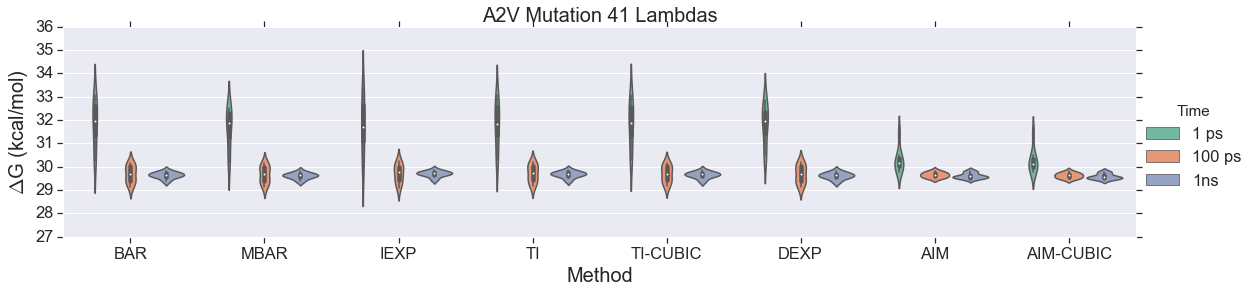

In [5]:
keys = ['BAR', 'MBAR', 'IEXP', 'TI', 'TI-CUBIC', 'DEXP', 'AIM', 'AIM-CUBIC']
# Plot the results using error bars for each lambda window
df = pd.DataFrame()
for i in keys:
    ddf = pd.DataFrame()
    ddf['1 ps'] = np.array(results['1ps'][i].apply(np.vectorize(am.convert_to_kcal)))
    ddf['100 ps'] = np.array(results['100ps'][i].apply(np.vectorize(am.convert_to_kcal)))
    ddf['1ns'] = np.array(results['1ns'][i].apply(np.vectorize(am.convert_to_kcal)))
    ddf['key'] = i
    df = pd.concat([df,ddf])

melted_df = pd.melt(df,
                   id_vars = 'key',
                   value_vars = ['1 ps', '100 ps','1ns'],
                   var_name = 'Time',
                   value_name = 'DeltaG(kcal/mol)')

melted_df.columns = ['Method', 'Time','DeltaG(kcal/mol)']

g = sns.catplot(x="Method",
            y="DeltaG(kcal/mol)",
            hue="Time"
            ,data=melted_df,
            kind="violin",
            height=4,
            aspect=4,
            legend_out=True)

plt.ylabel("$\Delta$G (kcal/mol)", fontsize = 20)
plt.xlabel("Method", fontsize = 20)
plt.title("A2V Mutation 41 Lambdas", fontsize=20);


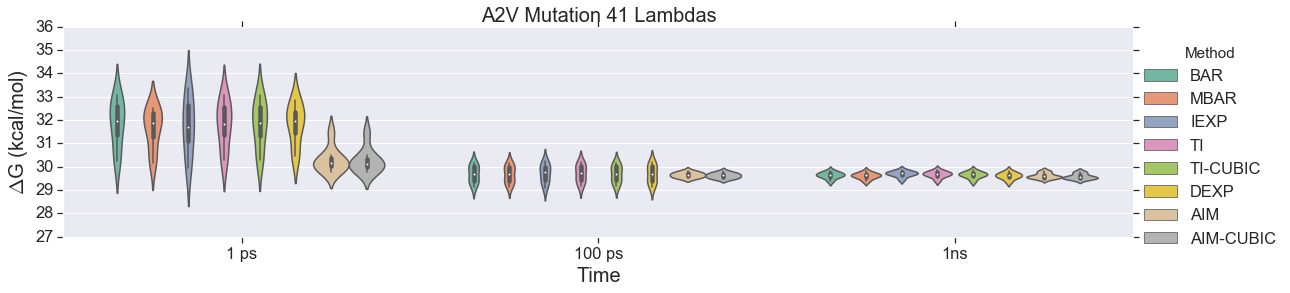

In [6]:
keys = ['BAR', 'MBAR', 'IEXP', 'TI', 'TI-CUBIC', 'DEXP', 'AIM', 'AIM-CUBIC']
# Plot the results using error bars for each lambda window
df = pd.DataFrame()
for i in keys:
    ddf = pd.DataFrame()
    ddf['1 ps'] = np.array(results['1ps'][i].apply(np.vectorize(am.convert_to_kcal)))
    ddf['100 ps'] = np.array(results['100ps'][i].apply(np.vectorize(am.convert_to_kcal)))
    ddf['1ns'] = np.array(results['1ns'][i].apply(np.vectorize(am.convert_to_kcal)))
    ddf['key'] = i
    df = pd.concat([df,ddf])

melted_df = pd.melt(df,
                   id_vars = 'key',
                   value_vars = ['1 ps', '100 ps','1ns'],
                   var_name = 'Time',
                   value_name = 'DeltaG(kcal/mol)')

melted_df.columns = ['Method', 'Time','DeltaG(kcal/mol)']

g = sns.catplot(x="Time",
            y="DeltaG(kcal/mol)",
            hue="Method"
            ,data=melted_df,
            kind="violin",
            height=4,
            aspect=4,
            legend_out=True)

plt.ylabel("$\Delta$G (kcal/mol)", fontsize = 20)
plt.xlabel("Time", fontsize = 20)
plt.title("A2V Mutation 41 Lambdas", fontsize=20);
